<a href="https://colab.research.google.com/github/zll134/deeplearning-tutorial/blob/master/OpenAI_Gym_CrossEntropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

导入必要的包，是openai gym能够在colab上运行

In [1]:
#安装必要的包
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install tensorboardX

In [0]:
# 导入需要的包
#Open_AI所需要的包
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
#神经网络需要的包
import torch 
import torch.nn as nn
import torch.optim as optim
from collections import namedtuple
from tensorboardX import SummaryWriter

#ipythondisplay.clear_output()#清除输出
#print('Done')

### OpenAI gym的使用
#### env类
env类有四个成员：<br>
- action_space：<br>
- observation_space<br>
- reset():该方法表示将环境初始化<br>
- step()：当action作为参数输入是，以python元组的形式返回四个信息分别是:
    - observation：返回的是numpy向量
    - reward：返回的是以个浮点数
    - done：如果为true则说明episode结束
    - extra_info：
    
创建环境（传统控制中的木杆平衡）:
木杆控制环境的观察空间为木杆中心的x坐标，以及x方向上的速度，以及木杆的旋转角度和旋转速度

### 使用交叉熵的方法进行强化学习

步骤：
1. 使用当前模型和环境进行N段episode的play
2. 计算N段episode的总reward。
3. 取前50%或者30%的episode进行训练。
4. 重复前面的步骤



In [3]:
hidden_size=128
batch_size=16
percentile=70

#我们要定义一个三层的神经网络，一个输入层，一个输出层和一个隐藏层,应该叫做mlp
class Net(nn.Module):
  def __init__(self,obs_size,hidden_size,n_action):
    super(Net,self).__init__();
    self.net=nn.Sequential(
        nn.Linear(obs_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size,n_action)
    )
  def forward(self,x):
    return self.net(x)

#两个辅助变量,用于将训
Episode=namedtuple('episode',['reward','steps'])#存储总的reward和动作集合
EpisodeStep=namedtuple('EpisodeStep',['observation','action'])#存储每一步的观察与动作

#定义一个迭代函数,tongguo episode生成批
def iteration_batches(env,net,batch_size):
  batch=[];
  episode_reward=0.0;
  episode_steps=[];
  obs=env.reset();
  sm=nn.Softmax();
  while True:
    #完成一次动作
    obs_v=torch.FloatTensor([obs]);
    act_probs_v=sm(net(obs_v));
    act_probs=act_probs_v.data.numpy()[0];
    action=np.random.choice(len(act_probs),p=act_probs);
    next_obs,reward,is_done,_=env.step(action)

    #存储一次动作的结果
    episode_reward+=reward;
    episode_steps.append(EpisodeStep(observation=obs,action=action));

    #如果一个episode结束就要采取下列动作
    if is_done:
      batch.append(Episode(reward=episode_reward,steps=episode_steps));
      episode_reward=0.0;
      episode_steps=[];
      next_obs=env.reset();
      if len(batch)==batch_size:
        yield batch#yield 表示函数下次从这个地方开始执行,在训练的时候表现他的作用
        batch=[]
    obs=next_obs

#筛选出，其中回报较高的episode，构成训练集
def filter_batch(batch,percentile):
  rewards=list(map(lambda s:s.reward,batch));
  reward_bound=np.percentile(rewards,percentile);
  reward_mean=float(np.mean(rewards));
  train_obs=[]
  train_act=[]
  for example in batch:
    if example.reward<reward_bound:
      continue;
    train_obs.extend(list(map(lambda step:step.observation,example.steps)));
    train_act.extend(list(map(lambda step:step.action,example.steps)));
  train_obs_v=torch.FloatTensor(train_obs);
  train_act_v=torch.LongTensor(train_act);
  return train_obs_v,train_act_v,reward_bound,reward_mean

#清除输出
#ipythondisplay.clear_output()
print('Done')

Done


开始训练

In [4]:
#开始训练
env = gym.make("CartPole-v0")#env是一个gym的env类
obs_size=env.observation_space.shape[0]
n_action=env.action_space.n;

#目标
net=Net(obs_size,hidden_size,n_action)
objective=nn.CrossEntropyLoss();#目标函数
optimizer=optim.Adam(params=net.parameters(),lr=0.01)#优化器
writer=SummaryWriter()

#开始训练
for iter_no,batch in enumerate(iteration_batches(env,net,batch_size)):
  obs_v,act_v,reward_b,reward_m=filter_batch(batch,percentile);
  optimizer.zero_grad();
  action_score_v=net(obs_v);
  loss_v=objective(action_score_v,act_v);
  loss_v.backward();
  print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
  optimizer.step();
  writer.add_scalar("loss", loss_v.item(), iter_no)
  writer.add_scalar("reward_bound", reward_b, iter_no)
  writer.add_scalar("reward_mean", reward_m, iter_no)
  if reward_m > 199:
    print("Solved!")
    break
writer.close()
#清除输出
#ipythondisplay.clear_output()
print('Done')

0: loss=0.702, reward_mean=20.4, reward_bound=22.5


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1: loss=0.680, reward_mean=27.6, reward_bound=31.0
2: loss=0.674, reward_mean=23.2, reward_bound=29.5
3: loss=0.684, reward_mean=26.2, reward_bound=30.0
4: loss=0.686, reward_mean=21.8, reward_bound=21.5
5: loss=0.658, reward_mean=28.9, reward_bound=34.0
6: loss=0.654, reward_mean=30.4, reward_bound=37.0
7: loss=0.651, reward_mean=44.2, reward_bound=60.5
8: loss=0.634, reward_mean=40.9, reward_bound=43.0
9: loss=0.627, reward_mean=40.8, reward_bound=41.0
10: loss=0.629, reward_mean=35.9, reward_bound=42.0
11: loss=0.609, reward_mean=43.0, reward_bound=50.5
12: loss=0.627, reward_mean=39.9, reward_bound=49.5
13: loss=0.603, reward_mean=38.3, reward_bound=47.0
14: loss=0.595, reward_mean=47.2, reward_bound=55.0
15: loss=0.599, reward_mean=47.5, reward_bound=56.5
16: loss=0.586, reward_mean=60.9, reward_bound=73.0
17: loss=0.572, reward_mean=53.9, reward_bound=58.0
18: loss=0.576, reward_mean=55.8, reward_bound=61.5
19: loss=0.564, reward_mean=52.1, reward_bound=60.5
20: loss=0.559, rewar

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1087'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1087'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

开始测试，观察算法的运行情况

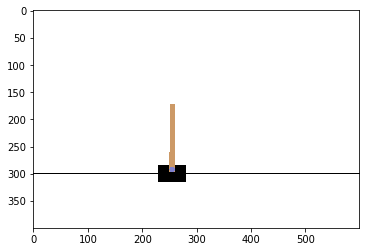

In [6]:
from gym import wrappers
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env,'/tmp/cartpole-experiment-1')
sm=nn.Softmax();
obs=env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
for i in range(500):
  
  #做出动作
  obs_v=torch.FloatTensor(obs)
  act_probs_v=sm(net(obs_v))
  act_probs=act_probs_v.data.numpy()
  print(act_probs)
  action=np.random.choice(len(act_probs),p=act_probs)
  next_obs,reward,is_done,_=env.step(action)

  #显示图形显示
  screen = env.render(mode='rgb_array')
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  #迭代更新
  obs=next_obs
  if is_done:
    break;
ipythondisplay.clear_output(wait=True)
env.close()


# 新段落